Start at 30.0[sec], finish at 40.0[sec], by time step 0.005[sec].
Input the (global)index of the target point:11980
start time:35
end time:36
A=1 or P=2 or Q=3?2
The point is in No.68 artery, and the local index is 14. Totally 30 points in this artery.


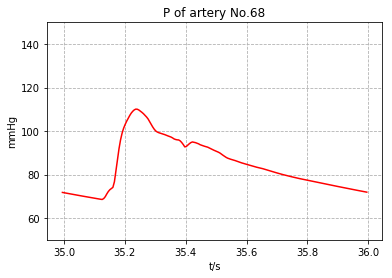

0.0720000267029 [sec] to draw the graph.
Press 1 for continue, 0 for quit:0


In [5]:
from __future__ import division
from  linecache import *
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time

def main():
    pathfile = "D:\\ploter\\ploter\\pathfile.csv"
    pathdf = pd.read_csv(pathfile)
    geomefile = pathdf.iloc[0,1]
    plotpath = pathdf.iloc[2,1]
    binpath = pathdf.iloc[1,1]
    vesnumloc,pointsinaartery,oncepointsnum,totaltimestep,starttime,timediff,endtime = getvesnumloc(binpath)
    #timeconvert = np.linspace(starttime,endtime,timediff)
    flag = 1
    while flag > 0:
        globalindex = input("Input the (global)index of the target point:")
        globalindex = int(globalindex)
        startt_raw = input("start time:")
        startt_raw = (startt_raw - starttime)/timediff
        startt = int(startt_raw)
        endt_raw = input("end time:")
        endt_raw = (endt_raw - starttime)/timediff
        endt = int(endt_raw)
        APQ = input("A=1 or P=2 or Q=3?")
        measuretime = time.time()
        apq,visarray,ylabel,ymax,ymin = decideApq(binpath,APQ,oncepointsnum,totaltimestep)
        vesnum,localarea = findpoint(geomefile,globalindex)
        elapsedtime = time.time() - measuretime
        plotoutone(apq,vesnumloc,visarray,plotpath,ylabel,vesnum,localarea,pointsinaartery,startt,endt,ymax,ymin)
        print "{} [sec] to draw the graph.".format(elapsedtime)
        flag = input("Press 1 for continue, 0 for quit:")
        flag = int(flag)
    

def decideApq(binpath,APQ,oncepointsnum,totaltimestep):
    if APQ == 1:
        apq = "A"
        ylabel = "mm"
        visarray = np.fromfile(binpath + '\\A_1d.dat',dtype=float)
        visarray = np.reshape(visarray,(totaltimestep,oncepointsnum))
        ymax = 10
        ymin = 0
    elif APQ == 2:
        apq = "P"
        ylabel = "mmHg"
        visarray = np.fromfile(binpath + '\\PP_1d.dat',dtype=float)
        visarray = np.reshape(visarray,(totaltimestep,oncepointsnum))
        ymax = 150
        ymin = 50
    elif APQ == 3:
        apq = "Q"
        ylabel = "ml/min"
        visarray = np.fromfile(binpath + '\\Q_1d.dat',dtype=float)
        visarray = np.reshape(visarray,(totaltimestep,oncepointsnum))
        ymax = 20
        ymin = 0
    else:
        print "error"
    return apq,visarray,ylabel,ymax,ymin

def findpoint(geomefile,globalindex):
    geometryfile = open(geomefile)
    lines = geometryfile.readlines()
    linelength = len(lines)
    geometryfile.close()
    count = 0
    for line in lines:
        count = count + 1
        if line.find("sequence_data") >=0:
            break
    for i in range(count+1,linelength+1):
        seqdata = getline(geomefile,i)
        seqdata = seqdata.split(' ')
        seqdata = np.array(seqdata,dtype=int)
        seqallpoint = seqdata[1]
        seqdatapure = seqdata[2:]
        if globalindex in seqdatapure:
            seqdata[0]
            localindex = np.where(seqdatapure == globalindex)
            break
    print "The point is in No.{} artery, and the local index is {}. Totally {} points in this artery.".format(seqdata[0],int(localindex[0]),seqdata[1]) 
    return seqdata[0],int(localindex[0])/seqdata[1]
        
def getvesnumloc(binpath):
    artnum = 93
    Array = np.fromfile(binpath + '\\A_1d.dat',dtype=float)
    AllElementNum = len(Array)
    count = 0
    i = -1
    vesloc = np.empty(0)
    for element in Array:
        i = i + 1
        if abs(element) < 1.0e-200:
            count = count + 1
            vesloc = np.append(vesloc,i)
            if count > (artnum ):
                break
    vesloc = vesloc.astype(np.int64)
    oncepointsnum = vesloc[-1] - 1
    vesloc = vesloc[0:-1]
    pointsinaartery = np.diff(vesloc)
    pointsinaartery = np.append(pointsinaartery,(oncepointsnum-vesloc[-1]))
    pointsinaartery = pointsinaartery.astype(np.int64)
    totaltimestep = int(AllElementNum/oncepointsnum)
    ArrayMatrix = np.reshape(Array,(totaltimestep,oncepointsnum))
    starttime = ArrayMatrix[0][0]
    timediff = ArrayMatrix[1][0] - starttime
    endtime = ArrayMatrix[-1][0]
    print "Start at {}[sec], finish at {}[sec], by time step {}[sec].".format(starttime,endtime,timediff)
    return vesloc,pointsinaartery,oncepointsnum,totaltimestep,starttime,timediff,endtime
    
def dfout(apq,array,path):
    arraydf = pd.DataFrame(array)
    arraydf.to_csv(path + "\\{}-array.csv".format(apq))
        
def plotoutone(apq,vesnumloc,visarray,path,ylabel,vesnum,localarea,pointsinaartery,startt,endt,ymax,ymin):
    numofves = vesnum
    pointofves = int(localarea*pointsinaartery[numofves])
    thisline = vesnumloc[numofves] + pointofves
    plt.subplots()
    plt.plot(np.linspace(visarray[startt,0],visarray[endt,0],endt-startt),visarray[startt:endt,thisline],color='red')
    plt.title("{} of artery No.{}".format(apq,numofves))
    plt.xlabel("t/s") 
    plt.ylabel(ylabel)
    plt.ylim(ymin, ymax)
    plt.grid(True,linestyle="dashed")
    plt.savefig(path + "\\{}-{}-{}.png".format(apq,numofves,pointofves))
    plt.show()
    
if __name__ == '__main__':
    main()